## **Andrey_Bondarchuk_346032105**

kaggle submit = 0.99256

collab  https://colab.research.google.com/drive/1g6rdLAHNWJshyAU_Cb_9dDoSjBBc9cfs#scrollTo=aq0dJVf1-dZc



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
#!pip install -U torch torchvision

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
torch.manual_seed(42)

In [9]:
import PIL
PIL.__version__

'7.1.2'

In [10]:
if True:
  from google.colab import drive
  drive.mount('/content/gdrive/')
  !unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [11]:
!ls train

simpsons_dataset


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Nov 14 12:14:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [12]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [14]:
from sklearn.metrics import f1_score

In [13]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
# # временно работаем на CPU
# DEVICE = torch.device("cpu")
# DEVICE

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [15]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [16]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [17]:
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [18]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [19]:
train_dataset = SimpsonsDataset(train_files, mode='train')

In [20]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

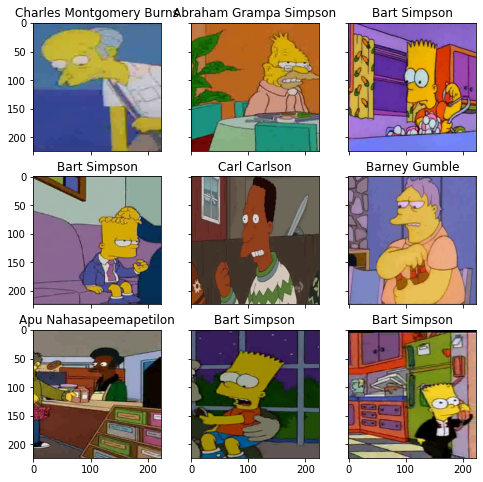

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [23]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [24]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [25]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [26]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [27]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [29]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [30]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [31]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=3, batch_size=64)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 2.496860035529326


epoch:  33%|███▎      | 1/3 [03:00<06:00, 180.36s/it]


Epoch 001 train_loss: 2.4969     val_loss 1.8290 train_acc 0.3165 val_acc 0.5055
loss 1.3941323367932306


epoch:  67%|██████▋   | 2/3 [05:59<02:59, 179.53s/it]


Epoch 002 train_loss: 1.3941     val_loss 1.1785 train_acc 0.6143 val_acc 0.6788
loss 0.878242132435772


epoch: 100%|██████████| 3/3 [08:58<00:00, 179.41s/it]


Epoch 003 train_loss: 0.8782     val_loss 0.9680 train_acc 0.7606 val_acc 0.7377


Построим кривые обучения

In [32]:
loss, acc, val_loss, val_acc = zip(*history)

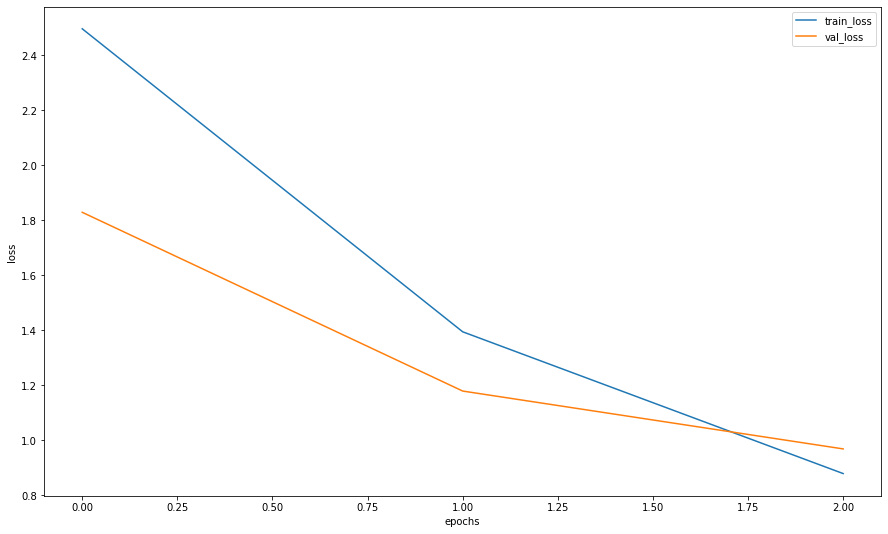

In [33]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [34]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [35]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [36]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [37]:
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))

In [40]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)
;
#f1_score(actual_labels, preds_class, average='macro')

''

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [41]:
f1_score(actual_labels, preds_class, average='macro')

0.3781305114638448

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

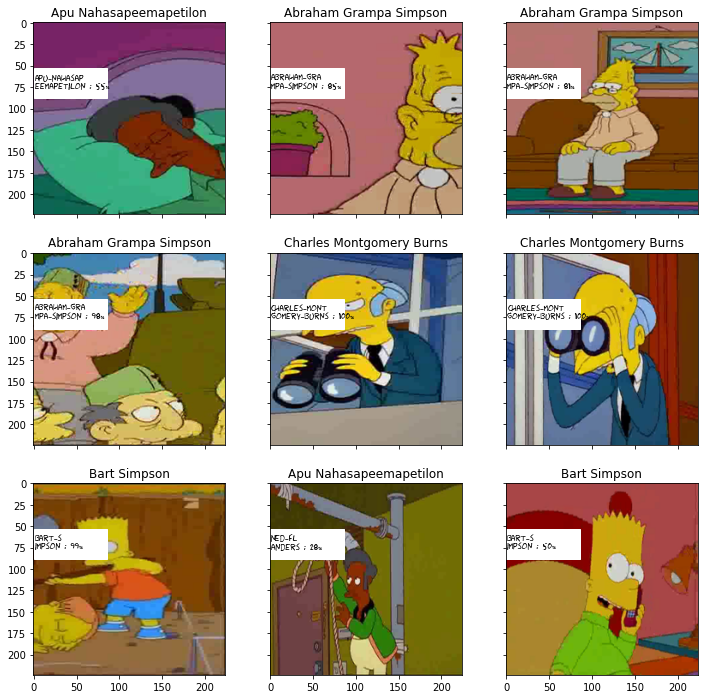

In [42]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [43]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [44]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [45]:
import pandas as pd

my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [46]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [47]:
my_submit.to_csv('cnn_baseline.csv', index=False)

In [48]:
# if torch.cuda.is_available():
#   torch.cuda.empty_cache()

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


### Нераспознанные классы

In [49]:
from collections import Counter
import pandas as pd
import random

In [50]:
# рассчитаем предсказания на всем val датасэте

imgs = [val_dataset[id][0].unsqueeze(0) for id in range(len(val_dataset))]
probs_ims = predict(simple_cnn, imgs)

y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in range(len(val_dataset))]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]

In [51]:
# функция рассчитывает accuracy для каждого класса

def calc_each_class_accuracy(actual_labels, preds_class):

    set_labels = set(train_val_labels) 

    result =  {_class: 0 for _class in set_labels}
    class_correct = {_class: 0 for _class in set_labels}
    class_total = {_class: 0 for _class in set_labels}

    for i in range(len(actual_labels)):
        class_correct[actual_labels[i]] += (actual_labels[i]==preds_class[i])
        class_total[actual_labels[i]] += 1

    for _class in set_labels:
        if class_total[_class]==0:
            result[_class]=0
        else:
            result[_class] = round(class_correct[_class]/class_total[_class],2)
    return result

Соберем датасет из нераспознанных классов и количества имеющихся данных по этим классам.

In [52]:
dict_accuracy = calc_each_class_accuracy(actual_labels, preds_class)

In [54]:
# датафрэйм по точности каждого класса
df_accuracy = pd.DataFrame(data=dict_accuracy, index=['Testacc']).T.reset_index()
df_accuracy.columns = ['class','accuracy']
df_accuracy = df_accuracy.sort_values(by='accuracy')

# датафрэм по количествам каждого класса
train_val_labels = [path.parent.name for path in train_val_files]
counter_class = Counter(train_val_labels)
df_class_count = pd.DataFrame(data=dict(counter_class), index=['TestCount']).T.reset_index()
df_class_count.columns = ['class','count']
df_class_count = df_class_count.sort_values(by='count')

#итоговый датафрэйм
df_class_count_acc = df_class_count.set_index('class').join(df_accuracy.set_index('class'), how='left', on='class').sort_values(by='accuracy')
df_class_count_acc

,count,accuracy
class,,
lionel_hutz,3,0.00
miss_hoover,17,0.00
martin_prince,71,0.11
professor_john_frink,65,0.12
snake_jailbird,55,0.21
sideshow_mel,40,0.30
agnes_skinner,42,0.30
ralph_wiggum,89,0.32
cletus_spuckler,47,0.33


**Вывод**: С увеличением количества данных точность распознавания в целом растет. Но, из этого правила есть исключения. Наприме, homer_simpson количество данных 2246 при низкой accuracy = 0.74. А в тоже время, troy_mcclure количество 8, а точность 1.

Посмотрим на персонажи, которые не удалась распознать в валидационном сэте. Для примера возьмем  'miss_hoover'

In [55]:
bad_class = 'miss_hoover'

bad_label = label_encoder.transform([bad_class])[0]

bad_characters = []
for i in range(len(val_dataset)):
    _, label = val_dataset[i]
    if label == bad_label:
        bad_characters.append(i)

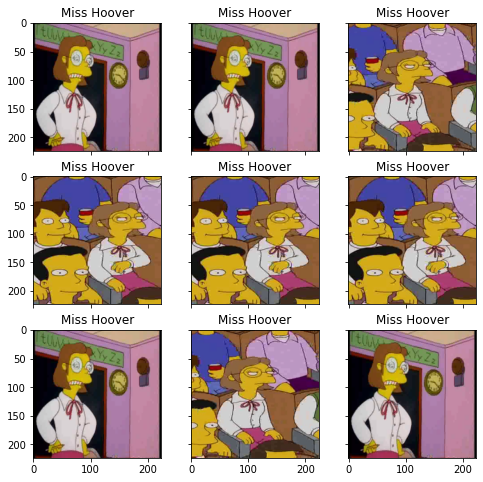

In [57]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = random.choice(bad_characters)
    im_val, label = val_dataset[random_characters]
     
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

**Вывод** Возможно 
, улучшиить точность нам поможет аугментация. Картинки в одинаковый профиль по данному персонажу.

### Анализ распределения по классам + Балансировка датасета

In [58]:
import seaborn as sns

In [59]:
train_val_labels = [path.parent.name for path in train_val_files]
counter_class = Counter(train_val_labels)
df = pd.DataFrame(data=dict(counter_class), index=['TestCount']).T.reset_index()
df.columns = ['class','count']
df = df.sort_values(by='count')

In [60]:
df.head()

,class,count
19,lionel_hutz,3
10,disco_stu,8
40,troy_mcclure,8
26,miss_hoover,17
12,fat_tony,27


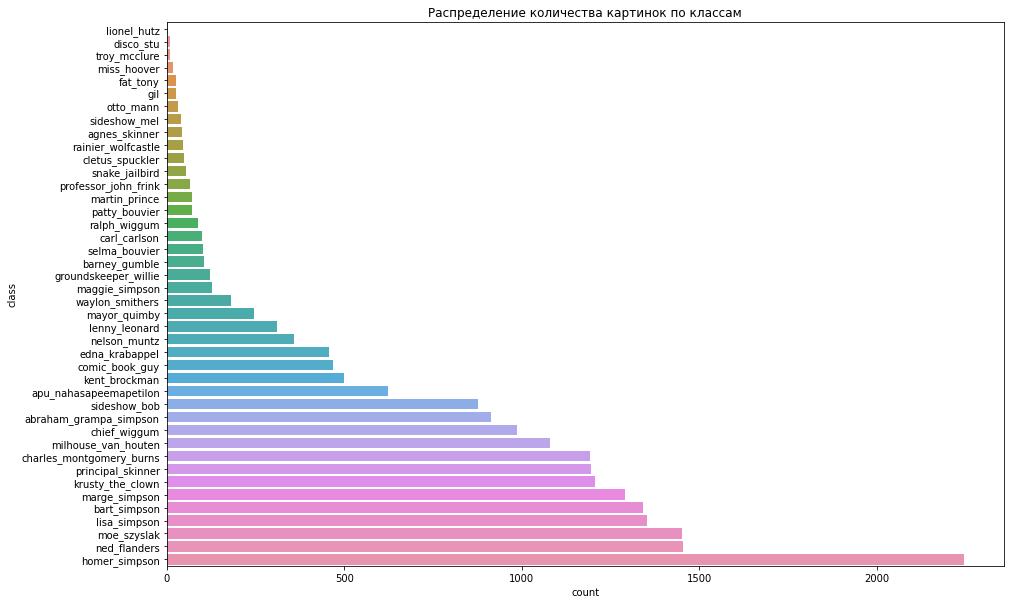

In [61]:
plt.figure(figsize=(15, 10));
sns.barplot(x="count", y="class", data=df);
plt.title('Распределение количества картинок по классам');

**Вывод:** Виден сильно выраженный дисбаланс по классам.

In [62]:
# вычислим 0.5 квантиль
redline = round(df['count'].quantile(0.5)) + 1
print("Quntile 0.5 = {}".format(redline))

Quntile 0.5 = 155


В нашем датасете нужно прооверсэмплить "бедные" классы по количеству картинок до 155.

#### Функция для увеличения (oversample) бедных классов

In [63]:
# Функция делает oversample по классам где количество картинок ниже заданного квартиля
# возвращает дополнительны список с добавленными элементами сэта
def add_balance_list(train_val_files, q=0.5):
    train_val_labels = [path.parent.name for path in train_val_files]
    counter_class = Counter(train_val_labels)
    df = pd.DataFrame(data=dict(counter_class), index=['TestCount']).T.reset_index()
    df.columns = ['class','count']
    df = df.sort_values(by='count')
    redline = round(df['count'].quantile(q)) + 1

    dict_class_path={}
    for item_class in df['class'].unique():
        path_list = []
        for item_path in [path for path in train_val_files if path.parent.name == item_class]:
            path_list.append(item_path)
        dict_class_path[item_class] = path_list

    additional_list = []
    for index, row in df.iterrows():
        if row['count'] < redline:
            add_count = redline - row['count'] 
            additional_list += list(np.random.choice(dict_class_path[row['class']], add_count, replace=True))
    return additional_list

In [64]:
#Добавляем данные до 0.5 квантиля
additional_list = add_balance_list(train_val_files, q=0.5)
oversample_train_val_files = train_val_files + additional_list
len(oversample_train_val_files)

22984

In [65]:
oversample_train_val_labels = [path.parent.name for path in oversample_train_val_files]
counter_class = Counter(oversample_train_val_labels)
oversample_df = pd.DataFrame(data=dict(counter_class), index=['TestCount']).T.reset_index()
oversample_df.columns = ['class','count']
oversample_df = oversample_df.sort_values(by='count')

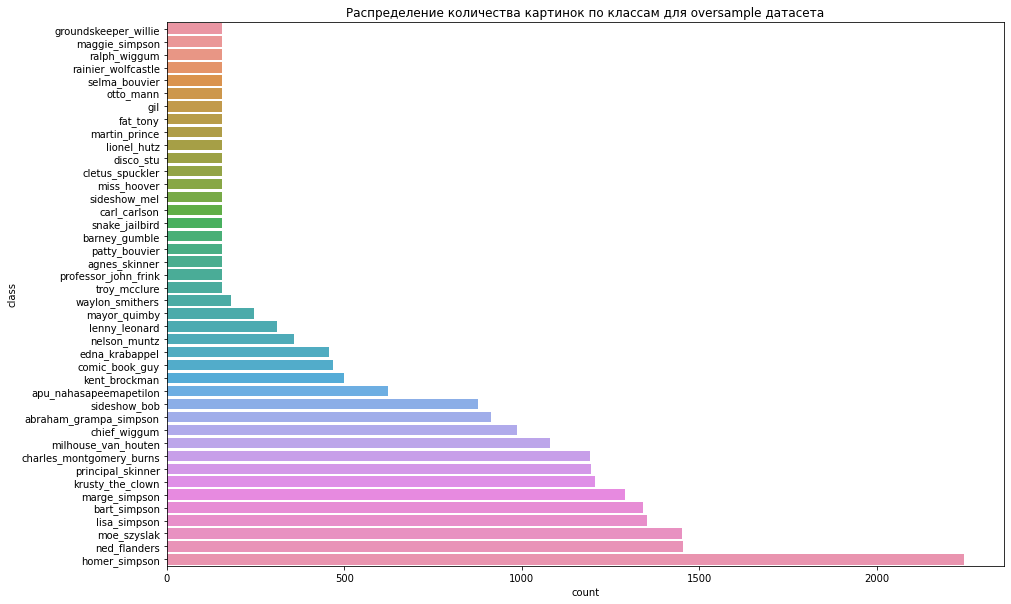

In [66]:
plt.figure(figsize=(15, 10));
sns.barplot(x="count", y="class", data=oversample_df);
plt.title('Распределение количества картинок по классам для oversample датасета');

### Класс SimpsonsDataset + RandomTransforms (Аугментация)

Подготовим новый класс для Симпсонов с аугментацией.

In [68]:
class SimpsonsDatasetRandomTransforms(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры с аугментацией 

    Dataset with pictures, which simultaneously loads them from folders
    performs scaling and transformation into torsion tensors with augmentation

    

    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('/content/label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):


        tranformer = {
            'train': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                # Random transforms -----------------------------------
                transforms.RandomRotation(degrees=15),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomAdjustSharpness(sharpness_factor=2),
                #transforms.RandAugment(),
                # -----------------------------------------------------  
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'val_test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
        }

        aug = (tranformer['train'] if self.mode == 'train' else tranformer['val_test'])
        x = self.load_sample(self.files[index])
        x = aug(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

## Fine Tune

Попробуем предобученные сетки из фрэйма torch. Начнем с Vgg16.

In [ ]:
%%capture
!pip3 install catalyst

In [ ]:
# добавляем импорты

from catalyst.utils import set_global_seed
from torchvision import transforms, models
from collections import Counter

import copy
import time

import torch.optim as optim
from torch.optim import lr_scheduler

Более удобная функция обучения, с оптимайзером и ранней остановкой при растущем loss на валидационной части сета.

In [ ]:
# новая функция обучения с оптимайзером и остановкой
# заимствовано у ArtyCrafty

def train_opt(train_files, val_files, model, epochs, batch_size, optimizer, scheduler=None, patience=None):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss =  np.inf
    patience_count = 0
    best_model = copy.deepcopy(model.state_dict())
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            set_global_seed(42 + epoch)
        
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if scheduler is not None:
                scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            if(best_val_loss > val_loss):
                patience_count = 0
                best_val_loss = val_loss
                best_model = copy.deepcopy(model.state_dict())
            if patience is not None:
                if(patience_count > patience):
                    break
            patience_count += 1
    model.load_state_dict(best_model)      
    return history

### VGG16

In [ ]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Заменим классификатор для нашей задачи

In [ ]:
n_classes = len(np.unique(train_val_labels))

vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn. Dropout(p=0.5, inplace=False),
    nn. Linear(in_features=4096, out_features=1000, bias=True),
    # наш слой для симпсонов
    nn.Linear(1000, n_classes)
)

Полностью размораживаем предобученную сеть.

In [ ]:
# размораживаем все слои
for param in vgg16.parameters():
    param.requires_grad = True

In [ ]:
if train_on_gpu:
  vgg16.cuda()

optimizer = optim.AdamW(vgg16.parameters(), lr=1e-4, weight_decay=0.005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 1.1502196416026262


epoch:  17%|█▋        | 1/6 [11:25<57:08, 685.67s/it]


Epoch 001 train_loss: 1.1502     val_loss 0.4695 train_acc 0.7011 val_acc 0.8815
loss 0.26243900880668414


epoch:  33%|███▎      | 2/6 [22:46<45:30, 682.72s/it]


Epoch 002 train_loss: 0.2624     val_loss 0.3291 train_acc 0.9341 val_acc 0.9201
loss 0.04641006474595117


epoch:  50%|█████     | 3/6 [34:08<34:07, 682.36s/it]


Epoch 003 train_loss: 0.0464     val_loss 0.2298 train_acc 0.9885 val_acc 0.9509
loss 0.011771666669228412


epoch:  67%|██████▋   | 4/6 [45:28<22:42, 681.37s/it]


Epoch 004 train_loss: 0.0118     val_loss 0.2504 train_acc 0.9980 val_acc 0.9526
loss 0.004449683209818177


epoch:  83%|████████▎ | 5/6 [56:49<11:21, 681.25s/it]


Epoch 005 train_loss: 0.0044     val_loss 0.2550 train_acc 0.9995 val_acc 0.9534
loss 0.0039307871738547984


epoch: 100%|██████████| 6/6 [1:08:09<00:00, 681.62s/it]



Epoch 006 train_loss: 0.0039     val_loss 0.2598 train_acc 0.9996 val_acc 0.9541


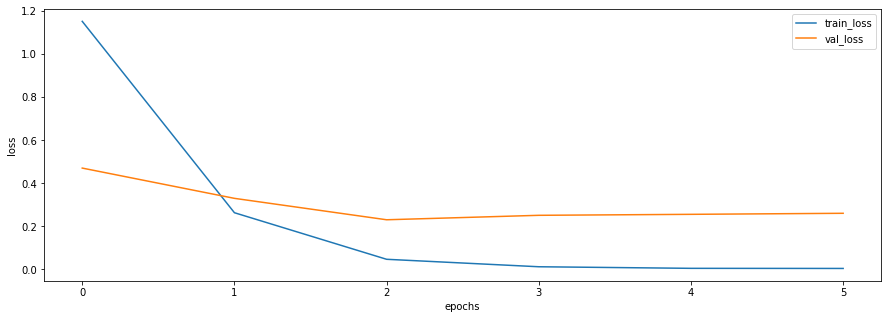

CPU times: user 1h 7min 53s, sys: 23.8 s, total: 1h 8min 17s
Wall time: 1h 8min 9s


In [ ]:
%%time
history = train_opt(train_dataset, val_dataset, 
                model=vgg16, epochs=6, 
                batch_size=64, optimizer=optimizer,
                scheduler=exp_lr_scheduler
                )

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
import copy

if False: #заблокировано
  # сохранить веса нашей нейросети model
  model_weights = copy.deepcopy(vgg16.state_dict())
  torch.save(model_weights, "/content/vgg_wights.pth") 

  # загружаем сохраненное состояние весов нейросети
  # model.load_state_dict(torch.load("path_to\\model_wights.pth"))
  # model.eval()# переключаем нейросеть в режим обучения

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(vgg16, test_loader)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
submission.to_csv('vgg16.csv', index=False)

In [ ]:
torch.cuda.empty_cache()

##### kaggle submit = 0.98618

**Вывод**: Сеть Vgg16 без оверсэмпла и аугментации, но с размораживанием весов дает уже вполне приличный результат.

### VGG16 + Oversample + Аугментация (RandomTransforms)

Подготовим новый сет симпосонов с оверсэмплом и аугментацией

In [ ]:
oversample_train_val_labels = [path.parent.name for path in oversample_train_val_files]

oversample_train_files, oversample_val_files = train_test_split(oversample_train_val_files, test_size=0.25, \
                                          stratify=oversample_train_val_labels)



oversample_val_dataset = SimpsonsDatasetRandomTransforms(oversample_val_files, mode='val')
oversample_train_dataset = SimpsonsDatasetRandomTransforms(oversample_train_files, mode='train')

In [ ]:
vgg16 = models.vgg16(pretrained=True)

n_classes = len(np.unique(oversample_train_val_labels))

vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn. Dropout(p=0.5, inplace=False),
    nn. Linear(in_features=4096, out_features=1000, bias=True),
    # наш слой для симпсонов
    nn.Linear(1000, n_classes)
)

for param in vgg16.parameters():
    param.requires_grad = True

In [ ]:
vgg16.cuda()
optimizer = optim.AdamW(vgg16.parameters(), lr=1e-4, weight_decay=0.005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 1.2878692223164783


epoch:  17%|█▋        | 1/6 [11:12<56:02, 672.53s/it]


Epoch 001 train_loss: 1.2879     val_loss 0.4826 train_acc 0.6650 val_acc 0.8817
loss 0.2956722417618638


epoch:  33%|███▎      | 2/6 [22:07<44:07, 661.98s/it]


Epoch 002 train_loss: 0.2957     val_loss 0.3383 train_acc 0.9241 val_acc 0.9156
loss 0.1109752957688667


epoch:  50%|█████     | 3/6 [33:03<32:57, 659.29s/it]


Epoch 003 train_loss: 0.1110     val_loss 0.3316 train_acc 0.9702 val_acc 0.9299
loss 0.01601313937247108


epoch:  67%|██████▋   | 4/6 [44:08<22:03, 661.53s/it]


Epoch 004 train_loss: 0.0160     val_loss 0.2447 train_acc 0.9962 val_acc 0.9501
loss 0.003334253275892305


epoch:  83%|████████▎ | 5/6 [55:13<11:02, 662.78s/it]


Epoch 005 train_loss: 0.0033     val_loss 0.2564 train_acc 0.9994 val_acc 0.9515
loss 0.0015661545593833844


epoch: 100%|██████████| 6/6 [1:06:16<00:00, 662.73s/it]



Epoch 006 train_loss: 0.0016     val_loss 0.2699 train_acc 0.9997 val_acc 0.9520


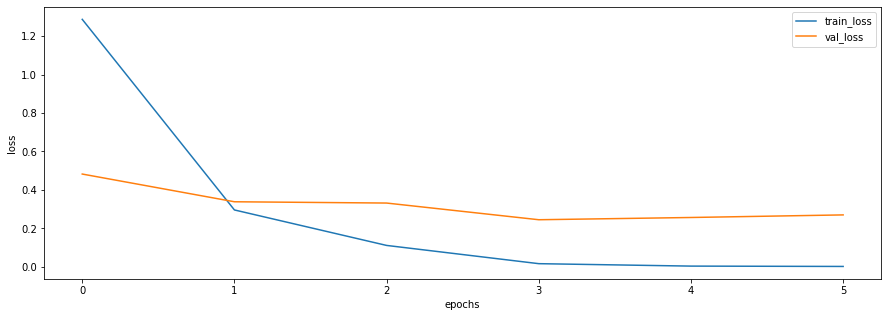

In [ ]:
history = train_opt(oversample_train_dataset, oversample_val_dataset, 
                model=vgg16, epochs=6, 
                batch_size=64, optimizer=optimizer,
                scheduler=exp_lr_scheduler
                )

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
# vgg16 ------------------------------------------------------------
probs = predict(vgg16, test_loader)
# ------------------------------------------------------------------
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
submission.to_csv('vgg16_over_aug.csv', index=False)

##### kaggle submit = 0.98724

**Вывод** Оверсэмпл и аугментация прибавили качества модели.

### EfficientNet  + Oversample + Аугментация (RandomTransforms)

In [ ]:
torch.cuda.empty_cache()

Воспользуемся другой предобученной сетью EfficientNet. 

Описание продукта можно посмотреть здесь https://github.com/lukemelas/EfficientNet-PyTorch

Снова делаем оверсэмпл и аугментацию для симпсонов.

In [ ]:
oversample_train_val_labels = [path.parent.name for path in oversample_train_val_files]

oversample_train_files, oversample_val_files = train_test_split(oversample_train_val_files, test_size=0.25, \
                                          stratify=oversample_train_val_labels)



oversample_val_dataset = SimpsonsDatasetRandomTransforms(oversample_val_files, mode='val')
oversample_train_dataset = SimpsonsDatasetRandomTransforms(oversample_train_files, mode='train')

In [69]:
%%capture
!pip install efficientnet_pytorch

In [70]:
from efficientnet_pytorch import EfficientNet

In [71]:
n_classes = len(np.unique(train_val_labels))

In [72]:
EfficientNet = EfficientNet.from_pretrained('efficientnet-b0', num_classes=n_classes)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
for param in EfficientNet.parameters():
    param.requires_grad = True

In [ ]:
#EfficientNet

In [ ]:
EfficientNet.cuda()
optimizer = optim.AdamW(EfficientNet.parameters(), lr=1e-4, weight_decay=0.005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.680494315446247


epoch:  10%|█         | 1/10 [07:03<1:03:31, 423.48s/it]


Epoch 001 train_loss: 1.6805     val_loss 0.4620 train_acc 0.6623 val_acc 0.8959
loss 0.26618437365165404


epoch:  20%|██        | 2/10 [14:03<56:10, 421.25s/it]


Epoch 002 train_loss: 0.2662     val_loss 0.1839 train_acc 0.9351 val_acc 0.9534
loss 0.0789242065430667


epoch:  30%|███       | 3/10 [21:01<48:59, 419.94s/it]


Epoch 003 train_loss: 0.0789     val_loss 0.1448 train_acc 0.9825 val_acc 0.9673
loss 0.024375392411832317


epoch:  40%|████      | 4/10 [28:01<42:00, 420.02s/it]


Epoch 004 train_loss: 0.0244     val_loss 0.1332 train_acc 0.9955 val_acc 0.9712
loss 0.01744617552907784


epoch:  50%|█████     | 5/10 [35:01<34:59, 419.91s/it]


Epoch 005 train_loss: 0.0174     val_loss 0.1355 train_acc 0.9968 val_acc 0.9708
loss 0.013876656671478528


epoch:  60%|██████    | 6/10 [42:00<27:58, 419.74s/it]


Epoch 006 train_loss: 0.0139     val_loss 0.1400 train_acc 0.9973 val_acc 0.9712
loss 0.01121272972747088


epoch:  70%|███████   | 7/10 [48:59<20:59, 419.95s/it]



Epoch 007 train_loss: 0.0112     val_loss 0.1406 train_acc 0.9980 val_acc 0.9708


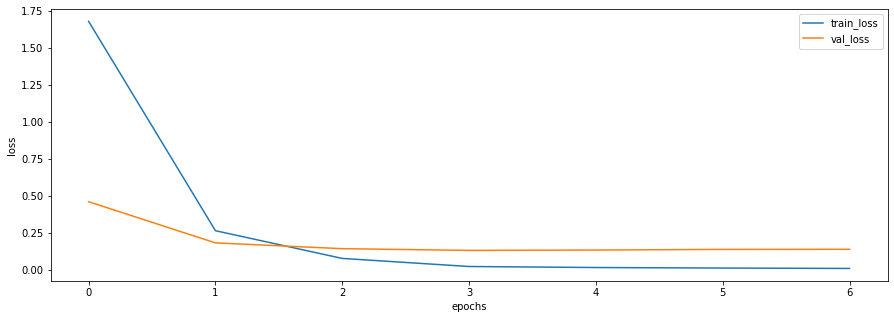

In [ ]:
history = train_opt(oversample_train_dataset, oversample_val_dataset, 
                model=EfficientNet, epochs=10, 
                batch_size=64, optimizer=optimizer,
                scheduler=exp_lr_scheduler, patience = 2
                )

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
# EfficientNet ----------------------------------------------------------
probs = predict(EfficientNet, test_loader)
# -----------------------------------------------------------------------
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
submission.to_csv('EfficientNet_mod_over_aug.csv', index=False)

Посмотрим точность распознавания по каждому классу

In [ ]:
imgs = [oversample_val_dataset[id][0].unsqueeze(0) for id in range(len(oversample_val_dataset))]
probs_ims = predict(EfficientNet, imgs)

y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[oversample_val_dataset[id][1]] for id in range(len(oversample_val_dataset))]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)

array([ 0,  0,  0, ..., 41, 41, 41])

In [ ]:
each_class_accuracy =  {_class: 0 for _class in set(actual_labels)}
class_correct = {_class: 0 for _class in set(actual_labels)}
class_total = {_class: 0 for _class in set(actual_labels)}

for i in range(len(actual_labels)):
    class_correct[actual_labels[i]] += (actual_labels[i]==preds_class[i])
    class_total[actual_labels[i]] += 1

for _class in each_class_accuracy:
    each_class_accuracy[_class] = round(class_correct[_class]/class_total[_class],2)

In [ ]:
each_class_accuracy

{'abraham_grampa_simpson': 1.0,
 'agnes_skinner': 0.95,
 'apu_nahasapeemapetilon': 1.0,
 'barney_gumble': 0.95,
 'bart_simpson': 1.0,
 'carl_carlson': 1.0,
 'charles_montgomery_burns': 1.0,
 'chief_wiggum': 1.0,
 'cletus_spuckler': 0.95,
 'comic_book_guy': 1.0,
 'disco_stu': 0.36,
 'edna_krabappel': 0.99,
 'fat_tony': 0.95,
 'gil': 0.92,
 'groundskeeper_willie': 1.0,
 'homer_simpson': 0.99,
 'kent_brockman': 1.0,
 'krusty_the_clown': 0.99,
 'lenny_leonard': 1.0,
 'lionel_hutz': 0.0,
 'lisa_simpson': 1.0,
 'maggie_simpson': 0.95,
 'marge_simpson': 1.0,
 'martin_prince': 1.0,
 'mayor_quimby': 0.98,
 'milhouse_van_houten': 1.0,
 'miss_hoover': 0.9,
 'moe_szyslak': 1.0,
 'ned_flanders': 0.99,
 'nelson_muntz': 0.98,
 'otto_mann': 0.92,
 'patty_bouvier': 0.87,
 'principal_skinner': 0.99,
 'professor_john_frink': 0.9,
 'rainier_wolfcastle': 0.95,
 'ralph_wiggum': 1.0,
 'selma_bouvier': 0.95,
 'sideshow_bob': 1.0,
 'sideshow_mel': 0.92,
 'snake_jailbird': 0.87,
 'troy_mcclure': 0.51,
 'waylon_

Не распознаны: 'lionel_hutz' = 0, 'troy_mcclure': 0.51 'disco_stu': 0.36,

##### kaggle submit = 0.99256 

**Вывод:** Предобученная сеть 'efficientnet-b0' дала отличный результат. Кроме того обучение данной сети происходит значительно быстрее чем vgg16. 

## **Итоги:**

**Наилучший результат по качеству и скорости обучения показала предобученная сеть EfficientNet b0 с размороженными весами. Предварительно количество бедных классов было увеличено до 155 экземпляров. Также использовалась Аугментация.**

**Результат на kaggle = 0.99256.**